# WeatherPy

Whether financial, political, or social -- data's true power lies in its ability to answer questions definitively. 

The Analysis consists in visualizing the weather of 500+ cities across the world of varying distance from the equator and 
creating a representative model of weather across world cities.


In [1]:
# Dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests as req
import time
from datetime import datetime

import openweathermapy.core as ow
from citipy import citipy


### FUNCTIONS SECTION

In [2]:
# Return coordinates of latitude and longitude 

def coordinates_func():
    # values should be between -90, 90  and -180, 180 
    return np.random.uniform(-92, 92), np.random.uniform(-182,182) 


In [3]:
# Change First character of string to uppercase

def first_upper(s):
   if len(s) == 0:
      return s
   else:
      return s[0].upper() + s[1:]


In [4]:
# Given a filename , return the contents of that file

def get_file_contents(filename):
    try:
        with open(filename, 'r') as f:
            # It's assumed our file contains a single line, with our API key
            return f.read().strip()
    except FileNotFoundError:
        print("'%s' file not found" % filename)

In [5]:
# Convert DATE in string format '%Y-%m-%d %H:%M:%S' to "%m/%d/%Y" or '%x'local format (US format)

def convert_date(day):
    
    day_str = datetime.strptime(str(day), '%Y-%m-%d %H:%M:%S')
    
    return(datetime.strftime(day_str, "%x"))
   

In [6]:
# The function is used for adding labels, getting the limits and saving the figure.

def set_plot_labels(x_title, y_title, day, x_limit , y_limit, savefig):
    
    # Add labels to the x and y axes
    
    title = "City "  +  x_title + " vs " + y_title + ' (' + day + ')'
    plt.title(title)
    plt.xlabel(x_title)    
    plt.ylabel(y_title)
    plt.grid(True)
    
    # Getting the limits
    plt.xlim(x_limit)
    plt.ylim(y_limit)
    plt.axvline(0, color='black', linestyle='dashed', alpha=0.5)
    plt.axhline(0, color='black', linestyle='dashed', alpha=0.5)
    figure_name="charts/WeatherPy_" + savefig + ".png"
    plt.savefig(figure_name)


### Generate Cities List

Randomly select at least 1000 unique (non-repeat) cities based on latitude and longitude.

In [8]:
# Create a dataframe that randomly hold latitude, longitude, Near city, Near country

cities_df = pd.DataFrame()
cities_df['Near Latitude'] = " "
cities_df['Near Longitude'] = " "
cities_df['Near City'] = " "
cities_df['Country Code'] = " "

for x in range(3000):
    
    # Call coordinates function to generate randomly a pair of latitude, longitude
    lat_long = coordinates_func() 
    lat, long = lat_long
    
    # Get the city and the country code
    city= citipy.nearest_city(lat, long)
    cityname = first_upper(city.city_name)
    country = city.country_code.upper()
    
    # Fill up the Dataframe    
    cities_df.set_value(x,"Near Latitude",lat)
    cities_df.set_value(x,"Near Longitude",long)
    cities_df.set_value(x,"Near City",cityname)
    cities_df.set_value(x,"Country Code",country)
    
cities_df.describe()


,Near Latitude,Near Longitude,Near City,Country Code
count,3000.000000,3000.000000,3000,3000
unique,3000.000000,3000.000000,984,144
top,-1.402136,-1.556011,Rikitea,RU
freq,1.000000,1.000000,113,341


### Cleaning cities data

Finding how many duplicates cities are in the dataframe cities.df and  removing them with keeping only one ocurrence. 

In [9]:
cities_df.duplicated(subset=['Near City', 'Country Code']).sum()

cities_df.loc[cities_df.duplicated(subset=['Near City', 'Country Code'])].head()


,Near Latitude,Near Longitude,Near City,Country Code
15,-60.1264,-178.379,Vaini,TO
25,-88.9992,-21.5232,Ushuaia,AR
34,62.1057,-108.355,Yellowknife,CA
37,-71.0555,-26.6881,Ushuaia,AR
39,-78.7243,84.5259,Busselton,AU


In [10]:
# Drop duplicate rows in cities_df except for the first ocurrence.

cities_df.drop_duplicates(subset=['Near City', 'Country Code'], keep="first", inplace=True)
cities_df.head()


,Near Latitude,Near Longitude,Near City,Country Code
0,0.937464,73.931,Viligili,MV
1,40.3065,174.503,Nikolskoye,RU
2,-10.4589,-23.8301,Georgetown,SH
3,30.3989,104.892,Jiancheng,CN
4,48.6061,84.0054,Kurchum,KZ


In [11]:
cities_df.describe()

,Near Latitude,Near Longitude,Near City,Country Code
count,985.000000,985.000000,985,985
unique,985.000000,985.000000,984,144
top,-1.587466,-1.937249,San ramon,RU
freq,1.000000,1.000000,2,132


In [12]:
sample_cities_df= cities_df.sample(600)
sample_cities_df.head()

,Near Latitude,Near Longitude,Near City,Country Code
1104,35.6548,70.2616,Nuristan,AF
865,-19.9267,127.596,Kununurra,AU
196,-39.9658,-38.3207,Cidreira,BR
2558,13.4659,-15.412,Farafenni,GM
225,-42.2785,-49.8586,Mar del plata,AR


### Perform API Calls

Perform a weather check on each of the cities using a series of successive API calls.

In [13]:
# Save config information.
filename = 'apikey'

base_url = "http://api.openweathermap.org/data/2.5/weather?"
units = "imperial"

api_key = get_file_contents(filename)
print("Our API key is: %s" % (api_key))

Our API key is: a076080d7b99df1af5ac7c1f4ed773f9


In [14]:
set_1 = 1
count_citi= 0
weather_data = []

print("Beginning Data Retrieval")
print("-------------------------------------------------------------------------------------")

for index, row in sample_cities_df.iterrows():
      
    city= sample_cities_df.loc[index]["Near City"]
    country=sample_cities_df.loc[index]["Country Code"]
    
    count_citi+=1
    
    if (count_citi == 1):
        start_time = time.process_time()
        
    params = city + "," + country
    print("Processing Record " +  str(count_citi) +  " of Set "  + str(set_1) + " | "  + params )
    query_url = base_url + "appid=" + api_key + "&units=" + units + "&q="

    try:
        weather_response = req.get(query_url + params).json()
                
        if (weather_response.get("cod") == 200):
            weather_data.append(weather_response)
        else:
            print("City " + city + " not found")
    except:
        print ("I got an error")
        continue
   
    # Avoid locking 
    if ( count_citi == 60):
        set_1 += 1
        count_citi = 0
        end_time = time.process_time()
        processing_time = end_time - start_time
        print("Processed 60 countries in :  " + str(processing_time))
        time.sleep(30)

# Extract data from weather_data responses
city_data = [data.get("name") for data in weather_data]
country_data = [data.get("sys").get("country") for data in weather_data]
lat_data = [data.get("coord").get("lat") for data in weather_data]
lon_data = [data.get("coord").get("lon") for data in weather_data]
temp_data = [data.get("main").get("temp_max") for data in weather_data]
humidity_data = [data.get("main").get("humidity") for data in weather_data]
clouds_data = [data.get("clouds").get("all") for data in weather_data]
wind_data = [data.get("wind").get("speed") for data in weather_data]
date_data = [data.get("dt") for data in weather_data]

weather_data = {"City": city_data, "Country": country_data, "Latitude": lat_data, "Longitude": lon_data,
                "Max Temp (F)": temp_data, "Humidity (%)": humidity_data, "Cloudiness (%)": clouds_data, 
                "Win Speed (mph)": wind_data, "Date": date_data}

weather_data = pd.DataFrame(weather_data)
 

Beginning Data Retrieval
-------------------------------------------------------------------------------------
Processing Record 1 of Set 1 | Nuristan,AF
City Nuristan not found
Processing Record 2 of Set 1 | Kununurra,AU
Processing Record 3 of Set 1 | Cidreira,BR
Processing Record 4 of Set 1 | Farafenni,GM
Processing Record 5 of Set 1 | Mar del plata,AR
Processing Record 6 of Set 1 | Presidencia roque saenz pena,AR
Processing Record 7 of Set 1 | Waipawa,NZ
Processing Record 8 of Set 1 | Lashio,MM
Processing Record 9 of Set 1 | Pontianak,ID
Processing Record 10 of Set 1 | Khairpur,PK
Processing Record 11 of Set 1 | Khani,RU
City Khani not found
Processing Record 12 of Set 1 | Severo-kurilsk,RU
Processing Record 13 of Set 1 | Banda aceh,ID
Processing Record 14 of Set 1 | Sao filipe,CV
Processing Record 15 of Set 1 | Qeshm,IR
Processing Record 16 of Set 1 | Ahuimanu,US
Processing Record 17 of Set 1 | Atuona,PF
Processing Record 18 of Set 1 | Novobureyskiy,RU
Processing Record 19 of Set 1

Processing Record 53 of Set 3 | Viligili,MV
City Viligili not found
Processing Record 54 of Set 3 | Ventspils,LV
Processing Record 55 of Set 3 | Tarudant,MA
City Tarudant not found
Processing Record 56 of Set 3 | Chumikan,RU
Processing Record 57 of Set 3 | Burica,PA
City Burica not found
Processing Record 58 of Set 3 | Lasa,CN
City Lasa not found
Processing Record 59 of Set 3 | Nanortalik,GL
Processing Record 60 of Set 3 | Maxixe,MZ
Processed 60 countries in :  0.65625
Processing Record 1 of Set 4 | Ahipara,NZ
Processing Record 2 of Set 4 | Tabiauea,KI
City Tabiauea not found
Processing Record 3 of Set 4 | Liuzhou,CN
Processing Record 4 of Set 4 | Shellbrook,CA
Processing Record 5 of Set 4 | Tikhvin,RU
Processing Record 6 of Set 4 | Yellowknife,CA
Processing Record 7 of Set 4 | Cabo san lucas,MX
Processing Record 8 of Set 4 | Nakodar,IN
Processing Record 9 of Set 4 | Kaduna,NG
Processing Record 10 of Set 4 | Of,TR
Processing Record 11 of Set 4 | Bac lieu,VN
City Bac lieu not found
Proc

Processing Record 42 of Set 6 | Hamamatsu,JP
Processing Record 43 of Set 6 | Colares,PT
Processing Record 44 of Set 6 | Jiancheng,CN
Processing Record 45 of Set 6 | Surt,LY
Processing Record 46 of Set 6 | Kem,RU
Processing Record 47 of Set 6 | Sterling,US
Processing Record 48 of Set 6 | Nabire,ID
Processing Record 49 of Set 6 | Gat,LY
City Gat not found
Processing Record 50 of Set 6 | Gomel,BY
City Gomel not found
Processing Record 51 of Set 6 | Naze,JP
Processing Record 52 of Set 6 | Hanyang,CN
Processing Record 53 of Set 6 | Lakes entrance,AU
Processing Record 54 of Set 6 | San matias,BO
Processing Record 55 of Set 6 | Port elizabeth,ZA
Processing Record 56 of Set 6 | Honningsvag,NO
Processing Record 57 of Set 6 | Veraval,IN
Processing Record 58 of Set 6 | Jumla,NP
Processing Record 59 of Set 6 | Bairiki,KI
City Bairiki not found
Processing Record 60 of Set 6 | Pevek,RU
Processed 60 countries in :  0.8125
Processing Record 1 of Set 7 | Chuy,UY
Processing Record 2 of Set 7 | Santa ros

Processing Record 36 of Set 9 | Vaitape,PF
Processing Record 37 of Set 9 | Enterprise,US
Processing Record 38 of Set 9 | Novochernorechenskiy,RU
Processing Record 39 of Set 9 | Nouadhibou,MR
Processing Record 40 of Set 9 | Shelburne,CA
Processing Record 41 of Set 9 | Kaeo,NZ
Processing Record 42 of Set 9 | Aracuai,BR
Processing Record 43 of Set 9 | Teya,RU
Processing Record 44 of Set 9 | Midland,CA
Processing Record 45 of Set 9 | Ust-kut,RU
Processing Record 46 of Set 9 | Quesnel,CA
Processing Record 47 of Set 9 | Krasnoselkup,RU
City Krasnoselkup not found
Processing Record 48 of Set 9 | Puerto montt,CL
Processing Record 49 of Set 9 | Lumby,CA
Processing Record 50 of Set 9 | Finnsnes,NO
Processing Record 51 of Set 9 | Kashi,CN
Processing Record 52 of Set 9 | Kirovskiy,RU
Processing Record 53 of Set 9 | Grindavik,IS
Processing Record 54 of Set 9 | Slavyanka,RU
Processing Record 55 of Set 9 | Choa saidan shah,PK
Processing Record 56 of Set 9 | Dhaka,BD
Processing Record 57 of Set 9 | Ro

In [15]:
weather_data.describe()

,Cloudiness (%),Date,Humidity (%),Latitude,Longitude,Max Temp (F),Win Speed (mph)
count,530.000000,5.300000e+02,530.000000,530.000000,530.000000,530.000000,530.000000
mean,42.745283,1.514096e+09,78.539623,19.928604,18.706906,49.239264,7.875396
std,36.183282,1.424511e+03,20.334335,32.481979,88.954902,31.083024,5.663952
min,0.000000,1.514091e+09,0.000000,-46.600000,-175.200000,-47.650000,0.180000
25%,1.000000,1.514095e+09,67.000000,-8.882500,-65.222500,26.600000,3.490000
50%,40.000000,1.514096e+09,84.000000,22.785000,26.440000,57.295000,6.420000
75%,76.000000,1.514097e+09,94.000000,47.647500,95.197500,74.647500,10.290000
max,100.000000,1.514097e+09,100.000000,73.510000,179.320000,109.400000,37.980000


In [16]:
weather_data.head(10)

,City,Cloudiness (%),Country,Date,Humidity (%),Latitude,Longitude,Max Temp (F),Win Speed (mph)
0,Kununurra,40,AU,1514095200,44,-15.77,128.74,95.00,8.05
1,Cidreira,92,BR,1514096253,100,-30.17,-50.22,70.08,9.35
2,Farafenni,8,GM,1514096423,34,13.57,-15.60,59.73,12.26
3,Mar del Plata,0,AR,1514096423,59,-46.43,-67.52,53.97,23.22
4,Presidencia Roque Saenz Pena,76,AR,1514096424,76,-26.79,-60.44,73.05,16.46
5,Waipawa,88,NZ,1514096424,66,-39.94,176.59,67.56,9.35
6,Lashio,0,MM,1514096424,68,22.93,97.75,69.76,2.04
7,Pontianak,75,ID,1514093400,94,-0.02,109.34,77.00,8.05
8,Khairpur,0,PK,1514095200,64,27.53,68.76,68.00,6.93
9,Severo-Kurilsk,64,RU,1514096322,100,50.68,156.12,25.75,14.56


In [17]:
#Export weather_data to csv_file and remove index
weather_data.to_csv("output/WeatherPy.csv", sep=',')

# Change format of weather_data['Date'] from unix UTC to string format
weather_data['Date'] = pd.to_datetime(weather_data['Date'],unit='s')

### Latitude vs Temperature Plot


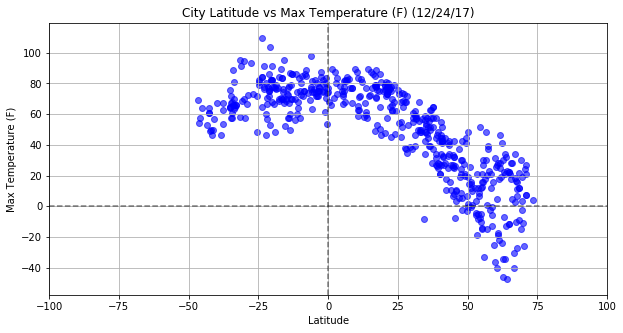

In [18]:
# Generate the Plot 

plt.figure(figsize=(10,5))
plt.scatter(weather_data.loc[:,"Latitude"],weather_data.loc[:,"Max Temp (F)"], marker='o', color="blue", alpha=0.6 )
max_temp = weather_data["Max Temp (F)"].max()+10
min_temp = weather_data["Max Temp (F)"].min()-10

day_value=convert_date(weather_data.loc[0,"Date"])
set_plot_labels("Latitude", "Max Temperature (F)", day_value, [-100,100], [min_temp,max_temp], "fig1")

# Show the figure
plt.show()

### Longitude vs Temperature Plot

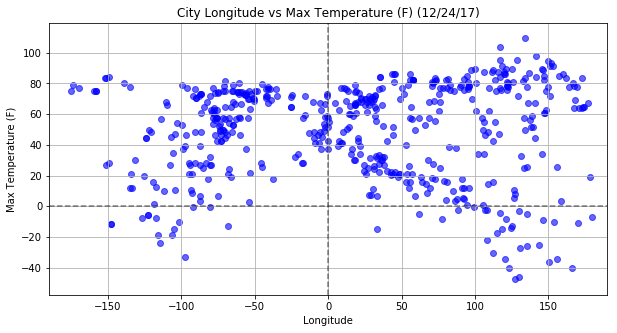

In [19]:
# Generate the plot

plt.figure(figsize=(10,5))
plt.scatter(weather_data.loc[:,"Longitude"],weather_data.loc[:,"Max Temp (F)"], marker='o', color="blue", alpha=0.6 )
set_plot_labels("Longitude", "Max Temperature (F)", day_value, [-190,190], [min_temp,max_temp], "fig2")

# Show the figure
plt.show()


### Humidity (%) vs. Latitude

-10


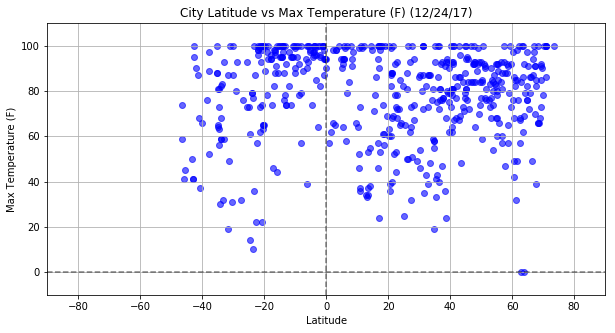

In [20]:
#Generate the plot

plt.figure(figsize=(10,5))
plt.scatter(weather_data.loc[:,"Latitude"],weather_data.loc[:,"Humidity (%)"], marker='o', color="blue", alpha=0.6 )
max_hum = weather_data["Humidity (%)"].max()+10
min_hum = weather_data["Humidity (%)"].min()-10
print (str(min_hum))

set_plot_labels("Latitude", "Max Temperature (F)", day_value, [-90,90], [min_hum,max_hum], "fig3")

# Show the figure
plt.show()

### Cloudiness (%) vs. Latitude

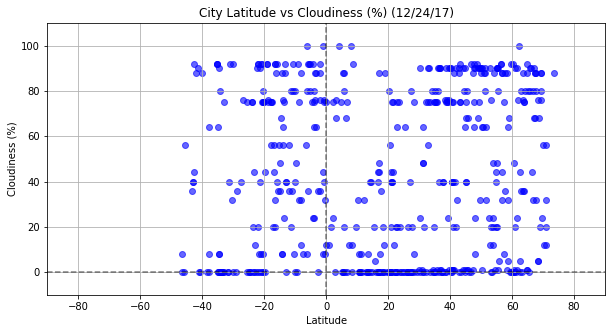

In [21]:
#Generate the plot

plt.figure(figsize=(10,5))
plt.scatter(weather_data.loc[:,"Latitude"],weather_data.loc[:,"Cloudiness (%)"], marker='o', color="blue", alpha=0.6 )

max_clouds = weather_data["Cloudiness (%)"].max()+10
min_clouds = weather_data["Cloudiness (%)"].min()-10

set_plot_labels("Latitude", "Cloudiness (%)", day_value, [-90,90], [min_clouds,max_clouds], "fig4")

# Show the figure
plt.show()

### Wind Speed (mph) vs. Latitude

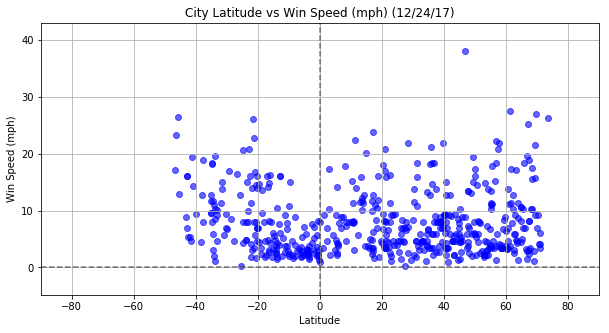

In [22]:
#Generate the plot

plt.figure(figsize=(10,5))
plt.scatter(weather_data.loc[:,"Latitude"],weather_data.loc[:,"Win Speed (mph)"], marker='o', color="blue", alpha=0.6 )

max_speed = weather_data["Win Speed (mph)"].max()+5
min_speed = weather_data["Win Speed (mph)"].min()-5

set_plot_labels("Latitude", "Win Speed (mph)", day_value, [-90,90], [min_speed,max_speed], "fig5")

# Show the figure
plt.show()